# Conditional Normalizing Flow Model

# **NOTE: THIS NOTEBOOK IS USEFUL FOR DEBUGGING, BUT THE tranFlow.sh WORKFLOW THAT USES train.py IS RECOMMENDED FOR ACTUAL APPLICATIONS**

Here, we train a conditional normalizing flow model $q(x|c)$. Our target $p(x|c)$ is a simple 2D Gaussian $\mathcal{N}(x|\mu, \sigma)$, where we condition on the mean $\mu$ and standard deviation $\sigma$, i.e. $c = (\mu, \sigma)$. We apply conditional autoregressive and coupling neural spline flows as well as a conditional masked autoregressive flow to the problem.

## Workflow
0. Before working in this notebook, you must first run simulations and the preprocess the data as it takes way too long to do interactively.
    1. For simulating data, see work_eic/slurm/makeJobs_full_theta_vary_z.sh
    1. for preprocessing the data see work_eic/macros/Time_estimation/preprocess_slurm/makeJobs_parallel.sh
    1. These use the slurm batch system to run on the dcc
    1. Once you have run these, you should have a few .pt files that contain tensors that can be read into this notebook
    1. These tensors should have 5 values, the first four being context and the last being the time value which is the feature (only the first two are used as context currently)
1. Load in the data and shuffle it to ensure data is randomly distributed in dataset; then separate into train and test sets
2. Define model
    1. Right now the autoregressive neural spline model seems to work well
    1. We have used masked affine coupling models before in the past but this doesn't seem like it would make sense here as we only have 1 feature and hence cannot mask it
3. Train the model with the training loop (unless you already have a pretrained model)
4. Save the model (or load)
5. Generate samples based on the context of your test dataset
6. Plot timing distribution
    7. The test distribution should match the sampled distribution pretty well since the samples are drawn from the same context as the test data

## Setup

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
import NF_util
from NF_util import PVect, theta_func, r_func,checkdir
from IPython.display import clear_output
import os
import datetime

x = datetime.datetime.now()
today = x.strftime("%B_%d")

In [2]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Data preparation
Need 5 features:
1. Three conditionals:
    1. Hit z position (calculate from shoot position and angle)
    2. hit theta (calculate from momentum vector)
    3. hit momenta (calculate from momentum vector)
2. Feature
    1. photon hit time on sensor
3. Extra
    1. mu incident time on scint (calculate from momentum and distance)
        1. We subtract this value from the photon hit time to get the relative time after photon creation (approximately)

##### Status
1. Hit z, hit theta, hit momenta and photon hit time are all good
1. Just need to calculate hit time from momentum (velocity) and distance traveled (use pythogorean theorem with x and z)

### Preprocess manually below if not loading data

### Load data from .pt file (created by preprocess.py)

August 6 dataset with revised z hit calc:

In [3]:
Timing_path = "/hpc/group/vossenlab/rck32/eic/work_eic/macros/NF_timing_modeling/"

raw_inputs = torch.load(f"{Timing_path}data/March_31/Run_1/Vary_p_events_filenum0_600_z_vals_55_5_mm_scint.pt")
for i in range(201):
    clear_output(wait=True)
    print(f"loaded file #{i+1} of 201")
    new_raw_input = torch.load(Timing_path + f"data/March_31/Run_1/Vary_p_events_filenum{i}_600_z_vals_55_5_mm_scint.pt")
    new_input = new_raw_input[new_raw_input[:,4] < 100]
    raw_inputs = torch.cat((raw_inputs, new_input),0)

loaded file #201 of 201


In [4]:
# inputs = raw_inputs[np.logical_and(raw_inputs[:,4] < 100,raw_inputs[:,3] < 0.06)]
inputs = raw_inputs

In [5]:
indexes = torch.randperm(inputs.shape[0])
dataset = inputs[indexes]
train_frac = 0.1
test_frac = 0.03
val_frac = 0.03
train_lim = int(np.floor(dataset.shape[0] * train_frac))
test_lim = train_lim + int(np.floor(dataset.shape[0] * test_frac))
val_lim = test_lim + int(np.floor(dataset.shape[0] * val_frac))
train_data = dataset[:train_lim]
test_data = dataset[train_lim:test_lim]
val_data = dataset[test_lim:val_lim]

In [8]:

# train_data = torch.load(Timing_path + f"data/combined/Jan_28/ten_percent_train_600_z_pos_train.pt")
# test_data = torch.load(Timing_path + f"data/combined/Jan_28/ten_percent_train_600_z_pos_test.pt")
# val_data = torch.load(Timing_path + f"data/combined/Jan_28/ten_percent_train_600_z_pos_val.pt")

/tmp/ipykernel_2324075/3440312556.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(Timing_path + f"data/combined/Jan_28/ten_percent_train_600_z_po

Text(0.5, 0, '(ns)')

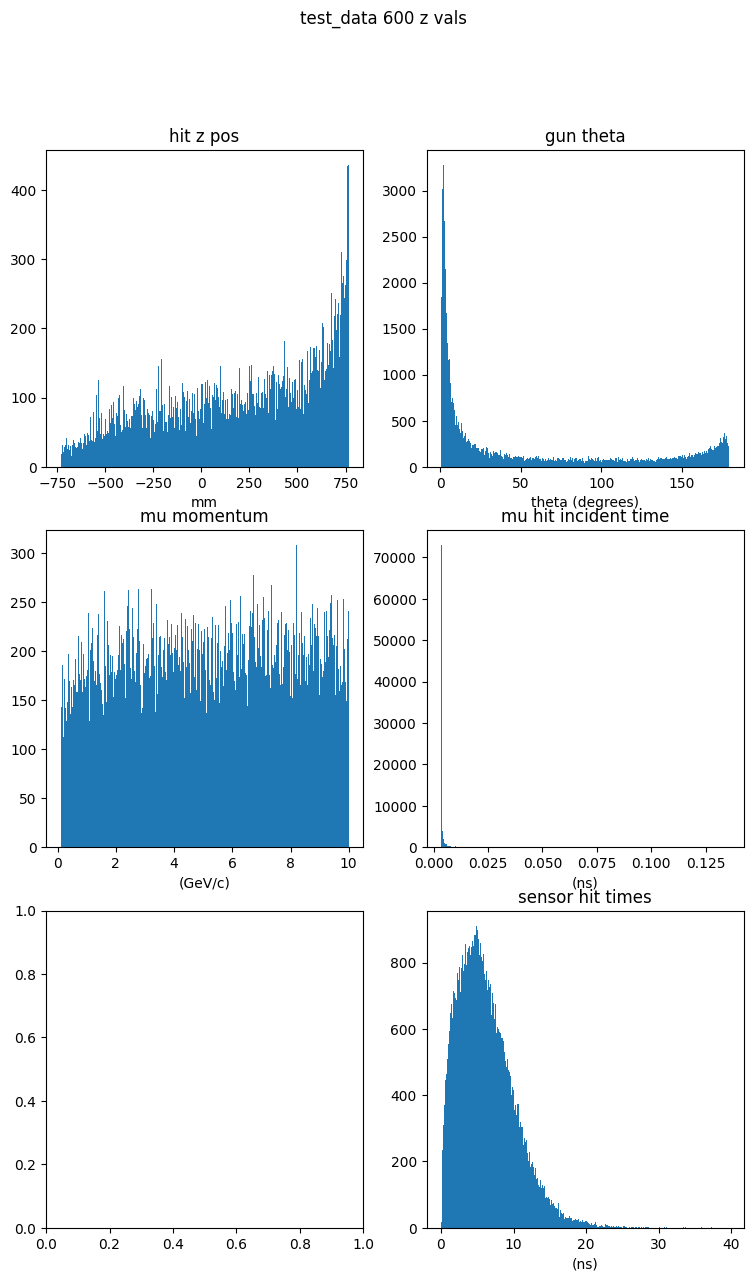

In [17]:
fig, axs = plot.subplots(3,2,figsize = (9,14))
fig.suptitle("test_data 600 z vals")
axs[0,0].hist(test_data[:100000,0],bins = 1000);
axs[0,0].set_title("hit z pos")
axs[0,0].set_xlabel("mm")

axs[0,1].hist(test_data[:100000,1],bins = 500);
axs[0,1].set_title("gun theta")
axs[0,1].set_xlabel("theta (degrees)")


axs[1,0].hist(test_data[:100000,2],bins = 500);
axs[1,0].set_title("mu momentum")
axs[1,0].set_xlabel("(GeV/c)")

axs[1,1].hist(test_data[:100000,3],bins = 500)
axs[1,1].set_title("mu hit incident time")
axs[1,1].set_xlabel("(ns)")


N, bins, patches = axs[2,1].hist(test_data[:100000,4],bins = 500)
axs[2,1].set_title("sensor hit times")
axs[2,1].set_xlabel("(ns)")

In [8]:
# fig.savefig("plots/inputs/july_21_run_1_sensor_time_incident_time_cuts.pdf")

## Masked Autoregressive Flow

## Neural Spline Flow

In [6]:
# Define flows
run_num = 2
run_num_str = str(run_num)

In [7]:
K = 8

latent_size = 1
hidden_units = 256
hidden_layers = 26
num_context = 3
batch_size= 20000
lr = 1e-4

lr_str = str(lr)
K_str = str(K)
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)
num_context_str = str(num_context)
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=num_context)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)

Create necessary directories

In [8]:

# model_path = "models/context_3/" + today + "/"
# checkdir(model_path)

model_path = "models/" + "March_31" + "/"
checkdir(model_path)

loss_path = "plots/loss/" + today + "/"
checkdir(loss_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)


In [9]:
run_info = "run_" + run_num_str+"_55_5mm_scint"+num_context_str+ "context_"+ K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs"

### Training

#### Train with Validation

In [ ]:
# Train model
def train_NF_timing(model,device, train_data, val_data, batch_size,num_context,num_epochs = 25, max_upticks = 5, validation_frequency = 2000):
    max_iter = int(np.floor(train_data.shape[0] / batch_size))
    train_loss_hist = np.array([])
    val_loss_hist = np.array([])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    early_stopping_dict = {
            "lowest_loss" : -1,
            "best_model_path" : "",
            "num_upticks" : 0
    }
    running_loss = 0
    global_step = 0
    for epoch in range(0,num_epochs):
        print(f"Beginning epoch #{epoch}")
        model.train()  # Set model to training mode
        for it in tqdm(range(max_iter)):
            optimizer.zero_grad()
            # Get training samples
            begin = it * batch_size
            end = (it + 1) * batch_size
            it_data = train_data[begin:end]
            context = torch.empty(it_data.size()[0], num_context)
            context[:,0] = it_data[:,0]
            context[:,1] = it_data[:,1]
            context[:,2] = it_data[:,2]
            context = context.to(device)
            samples = (it_data[:,4] - it_data[:,3]).unsqueeze(1).to(device)
            # Compute loss
            loss = model.forward_kld(samples, context)
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()
            # Log loss
            train_loss_hist = np.append(train_loss_hist, loss.to('cpu').data.numpy())
            running_loss += loss.to('cpu').data.numpy()
            global_step += 1

            # Validation step every 100 training steps
            if global_step % validation_frequency == 0:
                model.eval()  # Set model to evaluation mode
                val_loss = 0
                val_iter = min(100, int(np.floor(val_data.shape[0] / batch_size)))  # Limit validation to 100 batches
                with torch.no_grad():
                    for val_it in range(val_iter):
                        begin = val_it * batch_size
                        end = (val_it + 1) * batch_size
                        it_data = val_data[begin:end]
                        context = torch.empty(it_data.size()[0], num_context)
                        context[:,0] = it_data[:,0]
                        context[:,1] = it_data[:,1]
                        context[:,2] = it_data[:,2]
                        context = context.to(device)
                        samples = (it_data[:,4] - it_data[:,3]).unsqueeze(1).to(device)
                        loss = model.forward_kld(samples, context)
                        val_loss += loss.item()

                avg_val_loss = val_loss / val_iter
                print(f"train_loss: {running_loss / validation_frequency}\nval_loss: {avg_val_loss}")
                val_loss_hist = np.append(val_loss_hist, avg_val_loss)

                #Early stopping
                if(avg_val_loss < early_stopping_dict["lowest_loss"] or early_stopping_dict["lowest_loss"] == -1):
                    early_stopping_dict["lowest_loss"] = avg_val_loss
                    model.save(model_path + run_info + f"_checkpoint_e{epoch}.pth")
                    early_stopping_dict["best_model_path"] = model_path + run_info + f"_checkpoint_e{epoch}.pth"
                elif(avg_val_loss > early_stopping_dict["lowest_loss"]):
                    print("Validation loss increased, logging uptick...")
                    early_stopping_dict["num_upticks"] += 1
                if(early_stopping_dict["num_upticks"] >= max_upticks):
                    print("Exceeded max # of upticks, loading best model...")
                    model.load(early_stopping_dict["best_model_path"])
                    return model, train_loss_hist,val_loss_hist


    #             print(f"Step {global_step} - Train Loss: {train_loss_hist[-1]:.4f}, Val Loss: {avg_val_loss:.4f}")

                model.train()  # Set model back to training mode
                running_loss = 0
        print(f"Epoch {epoch} completed.")
    print(f"Exceeding max # epochs, loading best model...")
    model.load(early_stopping_dict["best_model_path"])

    return model, train_loss_hist,val_loss_hist
num_epochs = 25
model, train_loss_hist, val_loss_hist = train_NF_timing(model,device, train_data, val_data, batch_size,num_context = num_context, num_epochs = num_epochs, max_upticks = 5, validation_frequency = 2000)

Beginning epoch #0


 40%|███▉      | 1999/5028 [11:58<17:59,  2.81it/s]

train_loss: 33.57132339477539
val_loss: 26.055352001190187


 80%|███████▉  | 3999/5028 [24:08<06:00,  2.85it/s]  

train_loss: 31.41440773010254
val_loss: 23.44953430175781


100%|██████████| 5028/5028 [30:29<00:00,  2.75it/s]  


Epoch 0 completed.
Beginning epoch #1


 19%|█▉        | 971/5028 [05:46<24:01,  2.82it/s]

train_loss: 26.07469367980957
val_loss: 21.534466209411622


 59%|█████▉    | 2971/5028 [17:50<12:17,  2.79it/s] 

train_loss: 26.11717987060547
val_loss: 19.953453159332277


 98%|█████████▊| 4905/5028 [29:31<00:43,  2.83it/s]  

In [13]:
model.load("models/March_31/run_2_55_5mm_scint3context_8flows_26hl_256hu_20000bs_finished.pth")

In [ ]:
# Plot loss
plot.figure(figsize=(5, 5))
plot.scatter(range(len(train_loss_hist)),train_loss_hist, np.ones(len(train_loss_hist)) * 0.01, label='loss', alpha = 1)
plot.scatter(np.linspace(0,len(train_loss_hist),len(val_loss_hist)),val_loss_hist, np.ones(len(val_loss_hist)) * 0.1, label='loss', alpha = 1)
plot.savefig( loss_path + run_info + ".jpeg")
plot.legend()
plot.show()

In [9]:
# torch.save(test_data, test_data_path + "full_test_data_run_" + run_num_str+ "_"+ K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs.pt")

# test_data = torch.load(test_data_path + "full_test_data_run_" + run_num_str+ "_"+ K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs.pt")

### Evaluation

In [14]:
eval_batch_size = 10000
eval_max_iter = test_data.shape[0] // eval_batch_size

model = model.to("cuda")
test_data = test_data.to("cuda")
model.eval()
sampled_data = test_data.clone()
for i in tqdm(range(eval_max_iter)):
    begin = eval_batch_size * i
    end = eval_batch_size * (i + 1)
    with torch.no_grad():
        samples = abs(model.sample(num_samples = eval_batch_size, context = test_data[begin:end,:num_context])[0]).squeeze(1)
    sampled_data[begin:end,4] = samples.cpu() + test_data[begin:end,3].cpu()
    

100%|██████████| 1508/1508 [03:43<00:00,  6.75it/s]


In [15]:
torch.save(sampled_data,"data/samples/run_2_march_31.pt")
torch.save(test_data,"data/test/run_2_march_31.pt")

# samples = torch.load("data/samples/vary_p_uniform_12_flows_8hl_64hu_100bs.pt")
# test_data = torch.load("data/test/vary_p_uniform_12_flows_8hl_64hu_100bs.pt")

In [16]:
test_data = test_data.cpu()
sampled_data = sampled_data.cpu()

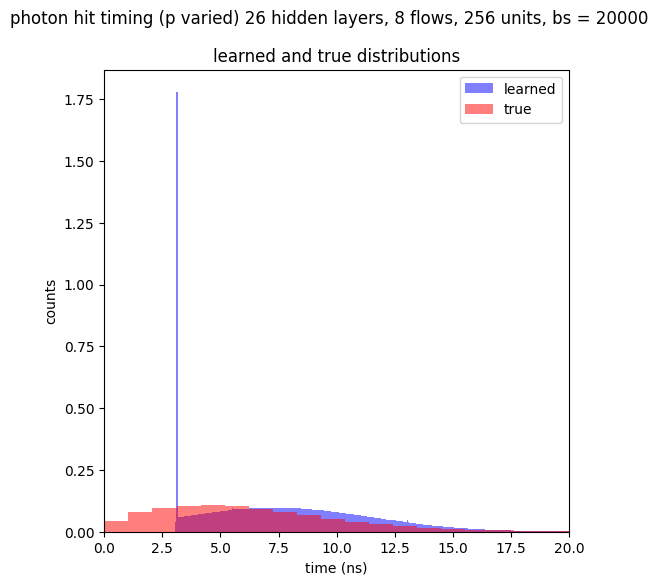

In [17]:
sample_fig, sample_axs = plot.subplots(1,1,figsize=(6,6))
sample_fig.suptitle("photon hit timing (p varied) 26 hidden layers, 8 flows, 256 units, bs = 20000")
sample_axs.hist(sampled_data[:,4],bins = 500, alpha = 0.5,color = 'b', label = 'learned', density = True)
sample_axs.set_title("learned and true distributions")
sample_axs.set_xlabel("time (ns)")
sample_axs.set_ylabel("counts")
sample_axs.hist(test_data[:,4],bins = 5000, color = 'r', alpha = 0.5, label = 'true', density = True)
sample_axs.legend(loc='upper right')
sample_axs.set(xlim=(0,20))
sample_fig.show()

In [16]:
# sample_fig.savefig("plots/test_distributions/vary_p_uniform_12_flows_8hl_64hu_100bs_normalized_resample.pdf")

In [35]:
# in_tensor has shape (n_photons, 5)
# Features: z pos, theta, momentum, muon hit time, photon hit time
def bin_z(in_tensor,n_bins, domain_lb = -750, domain_ub = 770):
    z_binned_times = [[] for i in range(n_bins)]
    bin_width = (domain_ub - domain_lb) / n_bins
    bin_centers = np.linspace(domain_lb + bin_width/2,domain_ub - bin_width/2,n_bins)
    for bin_idx in range(n_bins):
        bin_lb = bin_centers[bin_idx] - bin_width / 2
        bin_ub = bin_centers[bin_idx] + bin_width / 2
        curr_mask = (in_tensor[:,0] > bin_lb) & (in_tensor[:,0] < bin_ub)
        z_binned_times[bin_idx] = in_tensor[curr_mask][:,4]
    return z_binned_times

In [36]:
n_bins = 10
binned_z_samples = bin_z(sampled_data,10)
binned_z_truth = bin_z(test_data,10)

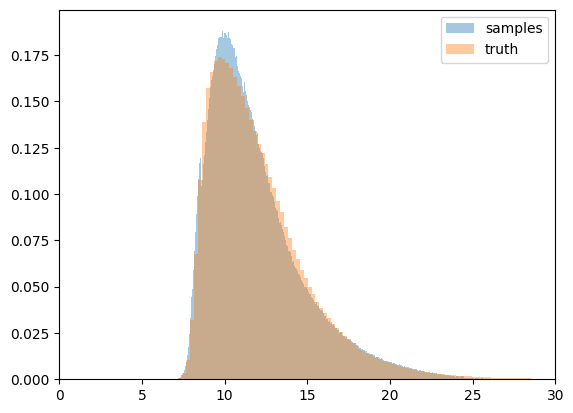

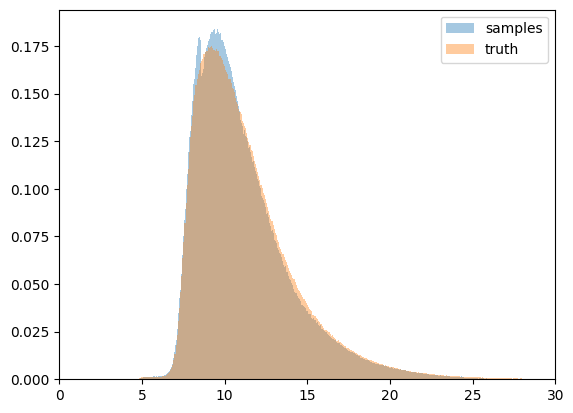

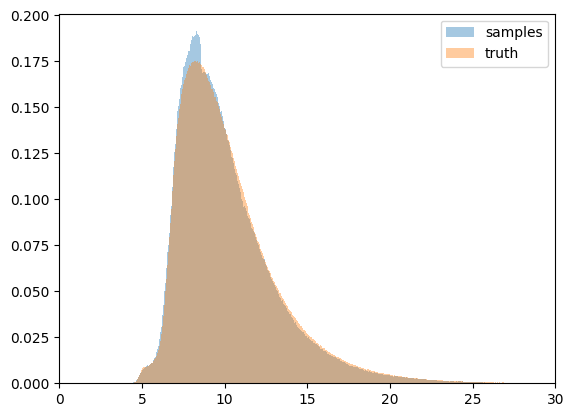

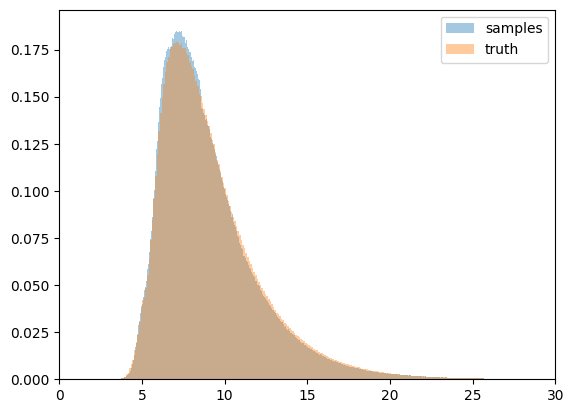

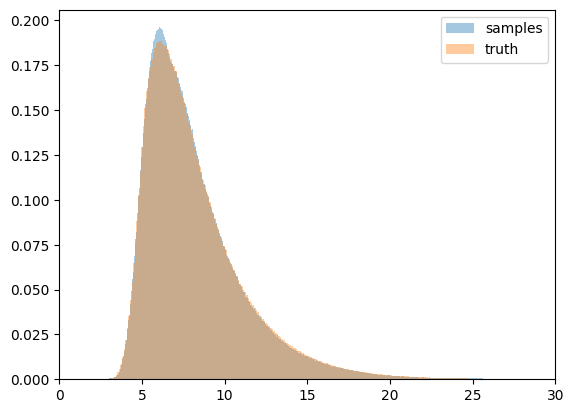

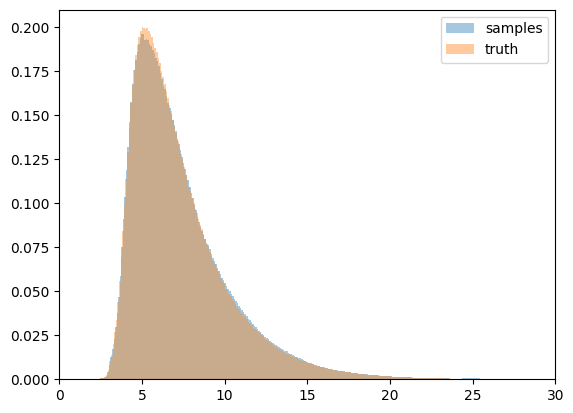

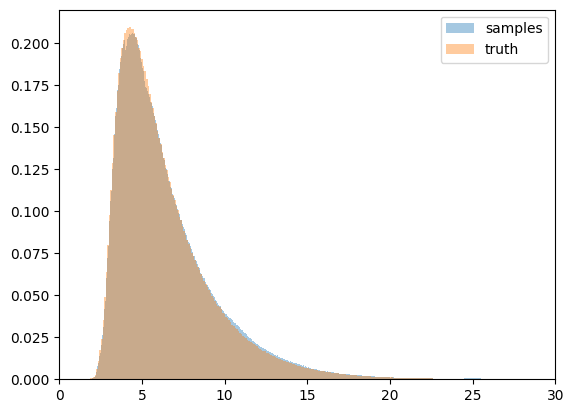

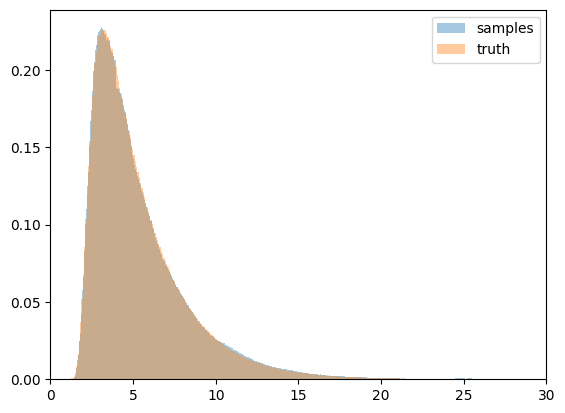

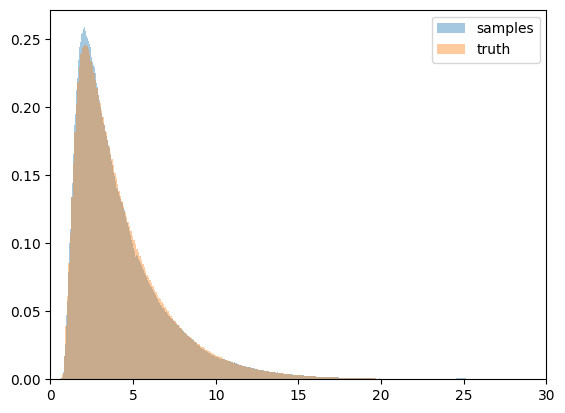

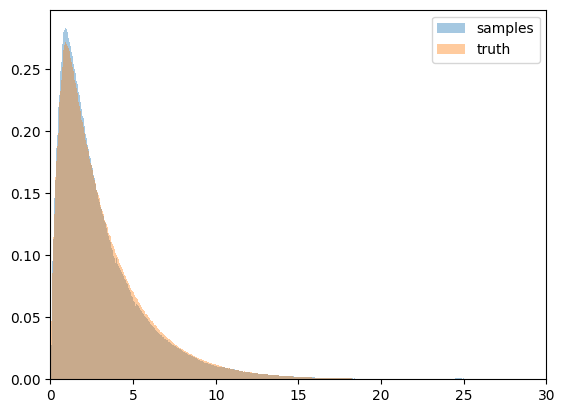

In [46]:
for bin_idx in range(n_bins):
    plot.hist(binned_z_samples[bin_idx],label = "samples",bins = 1000,alpha = 0.4,density = True);
    if(bin_idx == 0):
        plot.hist(binned_z_truth[bin_idx],label = "truth", bins = 5000,alpha = 0.4,density = True);
    else:
        plot.hist(binned_z_truth[bin_idx],label = "truth", bins = 1000,alpha = 0.4,density = True);
    plot.xlim(0,30)
    plot.legend()
    plot.show()